In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
(X_train_full, y_train_full), (
    X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

11501568/11490434 [==============================] - 0s 0us/step


In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [9]:
model = keras.models.Sequential(
    [keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
     keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
     keras.layers.MaxPool2D(), keras.layers.Flatten(),
     keras.layers.Dropout(0.25), keras.layers.Dense(128, activation="relu"),
     keras.layers.Dropout(0.5), keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

In [7]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.1093 - accuracy: 0.9664 - val_loss: 0.0523 - val_accuracy: 0.9856
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0352 - accuracy: 0.9885 - val_loss: 0.0430 - val_accuracy: 0.9874
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0192 - accuracy: 0.9935 - val_loss: 0.0527 - val_accuracy: 0.9880
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0128 - accuracy: 0.9956 - val_loss: 0.0661 - val_accuracy: 0.9856
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0097 - accuracy: 0.9967 - val_loss: 0.0538 - val_accuracy: 0.9896
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0058 - accuracy: 0.9981 - val_loss: 0.0782 - val_accuracy: 0.9896
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.0664 - val_accurac

[0.06562890857458115, 0.9876000285148621]

In [10]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1980 - accuracy: 0.9405 - val_loss: 0.0461 - val_accuracy: 0.9878
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0812 - accuracy: 0.9754 - val_loss: 0.0398 - val_accuracy: 0.9894
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0606 - accuracy: 0.9815 - val_loss: 0.0374 - val_accuracy: 0.9906
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0521 - accuracy: 0.9848 - val_loss: 0.0360 - val_accuracy: 0.9916
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0424 - accuracy: 0.9863 - val_loss: 0.0315 - val_accuracy: 0.9922
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0365 - accuracy: 0.9886 - val_loss: 0.0360 - val_accuracy: 0.9900
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0329 - accuracy: 0.9899 - val_loss: 0.0337 - val_accuracy:

[0.02675282023847103, 0.993399977684021]

### Neural style transfer

In [11]:
import os
import tensorflow as tf

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [19]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (24, 24)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [20]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [26]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg',
                                       'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

style_path = tf.keras.utils.get_file('kandinsky5.jpg',
                                     'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [27]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [28]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

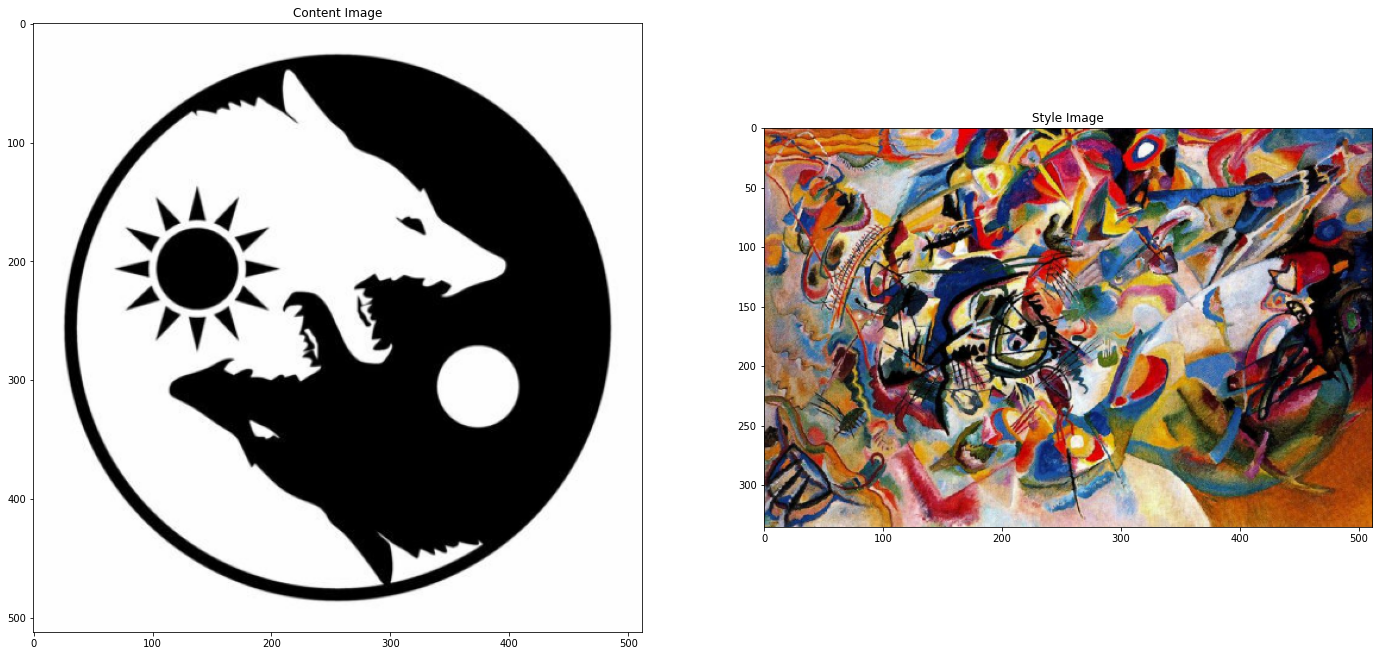

In [29]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

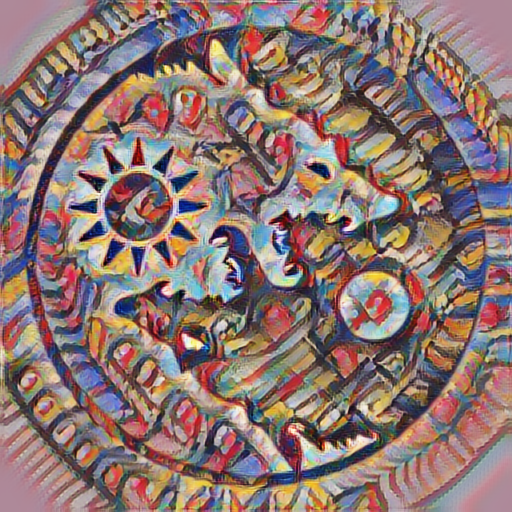

In [30]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)